In [6]:
## Import packages and set up environemnt
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
import pandas as pd
from IPython.display import clear_output
import time

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<IPython.core.display.Javascript object>


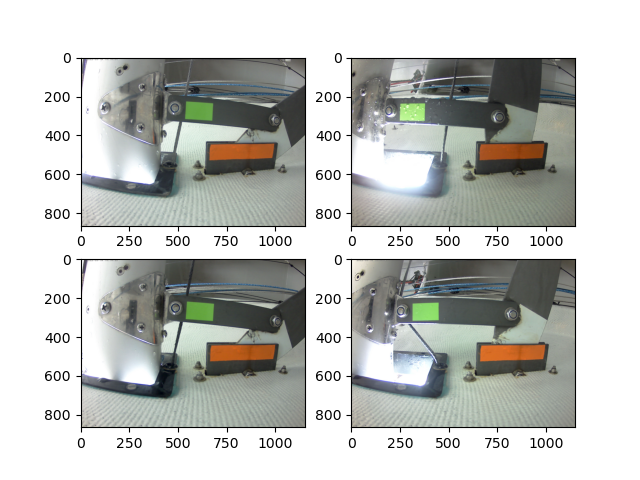

In [16]:
## get list of all file names in target directory and sample 4 photos to asses cropping and suitability as tuining photos
sample = [10,75,950,1000] # Set which 4 images to sample
try:
    #directory = '/mnt/veeringDL_storage/vsp_devPics/' # define directory
    directory = '/mnt/veeringDL_storage/e22_MG_vSpSamples_1/' # define directory
    file_list = [f for f in listdir(directory) if isfile(join(directory, f))] # inspect directory and return list of files

    ## Plot 4 sample images to select window
    plt.close()
    f, axarr = plt.subplots(2,2) # create 2 x 2 plot grid
    axarr[0,0].imshow(Image.open(directory+file_list[sample[0]]).reduce(int((4)))) # open image and plot to each sub plot
    axarr[0,1].imshow(Image.open(directory+file_list[sample[1]]).reduce(int((4))))
    axarr[1,0].imshow(Image.open(directory+file_list[sample[2]]).reduce(int((4))))
    axarr[1,1].imshow(Image.open(directory+file_list[sample[3]]).reduce(int((4))))

except:
    print("Error finding file names or plotting")

In [7]:
## Get user defined inputs
knownLength = 90 # known length of the stripe
offset = 158.49 # known zero offset
h1 = 30 # horizontal to start image at
h2 = 1050 # horizontal to end image at
v1 = 200 # vertical to start image at
v2 = 600 # vertical to end image at

In [8]:
## Import photos and time stamps and place into array and list repectevly
# the entire image set is stored in a single array shaped height, width, image, rgb
tic = time.perf_counter()
try:
    pixcels = np.empty((v2-v1, h2-h1, len(file_list) , 3), dtype = 'float32') # Create empty NP array for pixcels, type flat 32 for faiss later
    ts = [] # Create empty list for timestamps
    failedToLoad = [] #Empty list to record failed to load files
    index = 0 # set counter to 0
    for file in file_list: # loop over each file in file_list
        clear_output(wait=True)
        try:
            file_path = directory+file # define file path
            timeStamp = Image.open(file_path)._getexif()[36867] # import picture as Pillow Image object
            enchancer = ImageEnhance.Contrast(Image.open(file_path).reduce(int((4))))
            image = np.array(enchancer.enhance(3)) # load image and convert to array
            pixcels[:,:,index,:] = image[v1:v2, h1:h2, :] # crop array and load into pixcels array
            ts.append(timeStamp) # append time stamp to list
            index += 1 # increase index by 1
            print("importing "+file+ " file # "+str(index)+" of "+str(len(file_list)))
        except:
            failedToLoad.append(file) # if an image failes to load, record it in failed to load list and move to next image

    print(str(len(ts))+" Time stamps loaded and "+str(index)+" Images loaded from "+str(len(file_list))+" unique files found.")
except:
    print("Error loading images to array or getting time stamps")

toc = time.perf_counter()
getpics = toc - tic
print(getpics)

importing 20220319_155817A.jpg file # 1404 of 1404
1404 Time stamps loaded and 1404 Images loaded from 1404 unique files found.
194.86091117599972


<IPython.core.display.Javascript object>


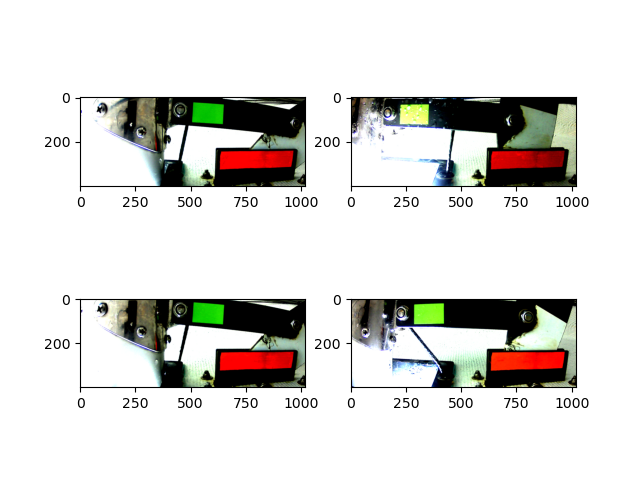

In [9]:
## replot sample images to ensure suitable
## Plot 4 sample images to select window
plt.close()
f, axarr = plt.subplots(2,2) # create 2 x 2 plot grid
axarr[0,0].imshow(pixcels[:,:,sample[0],:].astype('uint8')) # open image and plot to each sub plot
axarr[0,1].imshow(pixcels[:,:,sample[1],:].astype('uint8'))
axarr[1,0].imshow(pixcels[:,:,sample[2],:].astype('uint8'))
axarr[1,1].imshow(pixcels[:,:,sample[3],:].astype('uint8'))

In [11]:
## Get stripe and dot centroids and variation from sample photos
tic = time.perf_counter()

dotDist_list = [] # empty list to record the distances in dot clusters
stripeDist_list = [] # emoty list to record the distances in stripe clusters
dotCntr_list = [] # empty list to record the centre of dot clusters
stripeCntr_list = [] # empty list to record the centre of stripe clusters
sampleImages = np.empty((v2-v1, h2-h1, len(sample) , 3)) # create empty array to store sample images in to asses clusters
n = 0 # counter for for loop
measurments_ass = [] # create empty list to append measuremnts to
stipe_loc_ass = []
dot_loc_ass = []
stripe_const = np.array([[235.5,1.5,0]])
dot_const = np.array([[155,181,159]])
dot_med_list = []
stripe_med_list = []
stripe_len_list = []
delta_list = []
scale_list = []
stripe_wtf = []
clus_min = []


for i in range(len(file_list)): # iterate over the 4 images selected
    clear_output(wait=True)
    try:
        
        pix = pixcels[:,:,i,:] # extract one image from the pixcels array containing all images
        h, w, d = orig_shape = tuple(pix.shape) # store original shape of individual image in array
        pix_flat = np.reshape(pix, (h*w, d)) # flatten image for clustering
        pix_flat = pix_flat.astype('int') # make integer array for faster computation
        no_clusters = 3 # start clustering from 20 clusters
        clusterMin = 1 # set cluster min at 1 to enter while loop
        stripeColour_length = 10 # set inital count of potential stripe colours
        while clusterMin > 0.035 or stripeColour_length > 1: # continue to increase number of clusters until the smallest cluster becomes sufficently small to just be stripes
            try:
                kmeans = KMeans(n_clusters = no_clusters) # define cluster object
                cluster = kmeans.fit(pix_flat) # find clusters
                labels = cluster.labels_ # save cluster labels as a list
                if len(labels) < no_clusters: # check valid clusters are found and if not break out of while loop
                    break
                percent = np.unique(labels, return_counts=True) # get counts # pixels in each cluster
                dotColour = np.where(percent[1] == min(percent[1])) # return label of least frequent pixel as the dot colour
                stripeColour = np.intersect1d( # return label of cluster that is ~ 2.5x larger than the dot colour by finding the intersect of 2 np.where() calls
                    np.where(1.8 * min(percent[1]) < percent[1] ),
                    np.where(percent[1] < 2.3 * min(percent[1])) )
                clusterMin = min(percent[1]) / (h*w) # find fraction of picture occupied by smallest cluster
                stripeColour_length = len(stripeColour)
                no_clusters += 1 # increase cluster counter by 1
                if no_clusters > 10: # do not go past 50 clusters
                    print("breaking, to many clusters, image #"+str(i))
                    break
            except:
                print("clustering failed")
                break

        clus_min.append(clusterMin)
        ## Measure assesment images for compariosin against FAISS results
        if stripeColour:
            stripe_loc = np.array(np.where(np.reshape(labels, (h,w)) == stripeColour)) # create tuple of x and y values of the stripe cluster
        else:
            print("in Stripe exception")
            cnt = kmeans.cluster_centers_
            dist = 100000000
            for r in range(np.shape(cnt)[0]):
                if np.linalg.norm(cnt[r,:] - stripe_const) < dist:
                    dist = np.linalg.norm(cnt[r,:] - stripe_const)
                    stripeColour = r
    
            
            stripe_loc = np.array(np.where(np.reshape(labels, (h,w)) == stripeColour))
            print(percent[1][stripeColour]/percent[1][dotColour])
            stripe_wtf.append(percent[1][stripeColour]/percent[1][dotColour])
        
        try:
            dot_loc = np.array(np.where(np.reshape(labels, (h,w)) == dotColour )) # create tuple of x and y values of the dot cluster
    
        except:
            cnt = kmeans.cluster_centers_
            cnt = np.concatenate((cnt,dot_const))
            dotColour = np.where(pdist(cnt) == min(pdist(cnt)))
            dot_loc = np.array(np.where(np.reshape(labels, (h,w)) == dotColour ))

        U,S, Vh = np.linalg.svd(stripe_loc.T) # perfrom SVD on transposed stripe locations
        stripe_rot = stripe_loc.T @ Vh[:,0] # rotate stripe onto  first principle component
        dot_rot = dot_loc.T @ Vh[:,0] # rotate dot onto first principle component
        stripe_median = np.mean(np.percentile(stripe_rot,[75,25])) # find median of stripe
        dot_median = np.mean(np.percentile(dot_rot,[75,25])) # find median of dot
        iqr = np.subtract(*np.percentile(stripe_rot, [75, 25]))
        med = np.percentile(stripe_rot, 50)
        minus = med - iqr
        plus = med + iqr

        stripe_rot = stripe_rot[(minus < stripe_rot) & (stripe_rot < plus)]
        stripe_len = (abs(abs(np.min(stripe_rot)) - abs(np.max(stripe_rot)))) # fins the abs range of the stripe (known length)
        delta = 2 * abs(abs(stripe_median) - abs(dot_median)) #find the abs difference between the stripe and dot
        scale = knownLength / stripe_len # calculate the pixcel to mm scale
        measure = (delta * scale) - offset # calculate the actual measurment using the known scale and offset
        measure = 77 - measure
        measurments_ass.append(measure) # append measuremnt to list
        dot_med_list.append(dot_median)
        stripe_med_list.append(stripe_median)
        stripe_len_list.append(stripe_len)
        delta_list.append(delta)
        scale_list.append(scale)
        print("Dot Colour "+str(dotColour))
        print("Stripe Colour "+str(stripeColour))
        print('Clustering image #'+str(i)+" File Name = "+file_list[i])
        print(measure)

                    
    except: # is error append Nan
        measurments_ass.append('Nan')
        dot_med_list.append('Nan')
        stripe_med_list.append('Nan')
        stripe_len_list.append('Nan')
        delta_list.append('Nan')
        scale_list.append('Nan')
        print('f')

    if i in sample: # keep image of the sample images to assess later
        try:
            cluster.cluster_centers_[stripeColour] = np.asarray([0,255,0]) # change the stripe cluster centre to lime green
            cluster.cluster_centers_[dotColour] = np.asarray([255,0,0]) # change the dot colour centre to orange
            sampleImages[:,:,n,:] = np.reshape(cluster.cluster_centers_[cluster.labels_], orig_shape) # reshape array to fit sample Images and assign to respective picture
            n += 1 # increse counter by 1
        except:
            print('Sample image did not work')
    print("clustering "+str(i)+" of "+str(len(file_list)))

print('End clustering. The length of the dot Dist list is '+str(len(dotDist_list)))

## create pandas data frame and export as csv
df = pd.DataFrame(list(zip(
    ts, 
    file_list, 
    measurments_ass, 
    dot_med_list, 
    stripe_med_list, 
    delta_list, 
    scale_list,
    stripe_len_list)), 
                  columns = ['timeStamp', 
                             'file', 
                             'measurement',
                             'dot',
                             'stripe',
                             'delta',
                             'scale',
                             'len'])
df.to_csv('export.csv')
toc = time.perf_counter()
cluss = toc - tic
print(cluss/60)

Dot Colour (array([4]),)
Stripe Colour [3]
Clustering image #1403 File Name = 20220319_155817A.jpg
77.12555725196555
clustering 1403 of 1404
End clustering. The length of the dot Dist list is 0
91.67427915123335


<IPython.core.display.Javascript object>


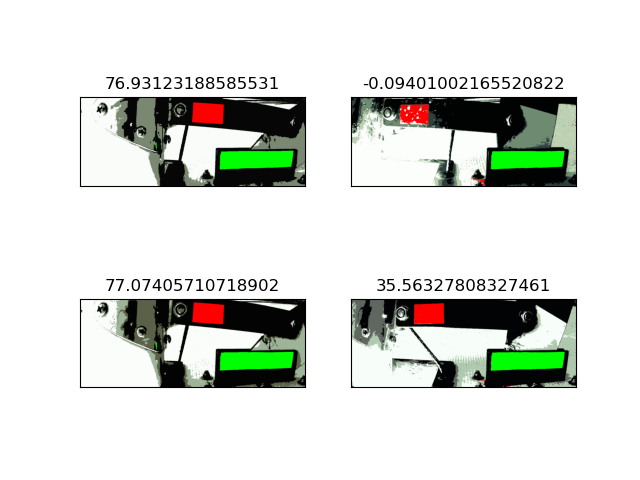

[]

In [15]:
## Plot assesment plots
plt.close()
f, axarr = plt.subplots(2,2) # create 2 x 2 plot grid
axarr[0,0].imshow(sampleImages[:,:,0,:].astype('uint8')) # open image and plot to each sub plot
axarr[0,0].title.set_text(measurments_ass[sample[0]])
axarr[0,0].set_xticks([])
axarr[0,0].set_yticks([])
axarr[0,1].imshow(sampleImages[:,:,1,:].astype('uint8'))
axarr[0,1].title.set_text(measurments_ass[sample[1]])
axarr[0,1].set_xticks([])
axarr[0,1].set_yticks([])
axarr[1,0].imshow(sampleImages[:,:,2,:].astype('uint8'))
axarr[1,0].title.set_text(measurments_ass[sample[2]])
axarr[1,0].set_xticks([])
axarr[1,0].set_yticks([])
axarr[1,1].imshow(sampleImages[:,:,3,:].astype('uint8'))
axarr[1,1].title.set_text(measurments_ass[sample[3]])
axarr[1,1].set_xticks([])
axarr[1,1].set_yticks([])